In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np
factorial = np.math.factorial
import matplotlib.pyplot as plt
import scipy.interpolate
import time 
import copy

# custom modules
import Surrogates.PolynomialChaosExpansion as PCE

from Models.Chaboche_Model.ChabocheModel import ChabocheModel
from Models.Chaboche_Model.ChabocheModel import chaboche_samples
from Models.Chaboche_Model.ChabocheModel import chaboche_uniform_isoprob_monotonic_transform
from Models.Chaboche_Model.ChabocheModel import generate_model_evaluations

# Model Evaluations

$\sigma(t; \, E, \sigma_{y|0}, Q_{iso}, b_{iso}, n_{iso}, D_{iso}, Q_{kin}, b_{kin} ;  \, \dot{\varepsilon}, \nu)$

## 8 Random Variables

($\nu$ if fixed to 0.3)

1. Young's Modulus: $E$

2. Initial Yield Limit: $\sigma_{y|0}$

### Isotropic Parameters

3. Isotropic Asympotote: $Q_{iso}$

4. Isotropic growth rate: $b_{iso}$

5. Isotrpic exponent: $n_{iso}$

6. Isotropic threshold: $D_{iso}$

### Kinematic Parameters

7. Kinematic Asympotote: $Q_{kin}$

8. Kinematic growth rate: $b_{kin}$



# Cyclic Loading

In [6]:
number_of_realizations = 100

# Time integration parameters
t_min = 0
t_max = 5000
delta_t = 1 # time step
n_t = int((t_max-t_min)/delta_t)

t_linspace = np.linspace(t_min, t_max, n_t+1)

max_strain = 3e-2
time_to_max_strain = 2500/8

model = ChabocheModel('1D', 'cyclic', max_strain, time_to_max_strain)

In [ ]:
SampleSpace = chaboche_samples(number_of_realizations)

func_evaluations = generate_model_evaluations(model, t_min, t_max, delta_t, 'implicit', SampleSpace, parallel_computation = True)

# plot solution corresponding to each set of random variable
model.stress_plot(t_min, t_max, delta_t, func_evaluations)

# Gauß-Legendre Quadrature

Exactly integrates polynomial of degree: 2*number_of_quadrature_points-1

numpy package has been tested upto 100 points

In [6]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights 

    return quad_points, quad_weights

## Interpolation at Quadrature Points

In [7]:
# Numerical integration in time: T = [0, 100]
number_quad_points = 50
n_t = int((t_max-t_min)/delta_t)
quad_time_points, quad_weights = GaussLegendreQuadrature(t_min, t_max, number_quad_points)

Quad_coord_weight_matrix = np.hstack((quad_time_points.reshape([-1, 1]), quad_weights.reshape([-1, 1])))

# Interpolation 
x_interpolate = np.linspace(t_min, t_max, n_t+1) # time

# store evaluated values at quadrature points
f_at_quad_points = np.zeros((number_of_realizations, number_quad_points))

for i in range(number_of_realizations):

    y_interpolate = func_evaluations[i,:]

    f_approximate = scipy.interpolate.interp1d(x_interpolate, y_interpolate, kind='cubic') # create callable from class scipy.interpolate

    f_at_quad_points[i, :] = f_approximate(quad_time_points) # use interpolation function returned by `interp1d`

## Plot of interpolated values at quadrature points

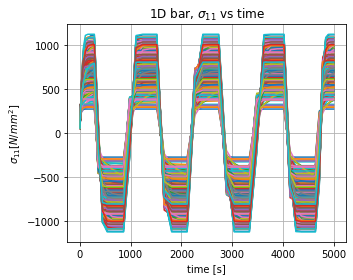

In [8]:
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(quad_time_points, f_at_quad_points.T)

ax.set_title(r'1D bar, $\sigma_{11}$ vs time')
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\sigma_{11} [N/mm^2]$')
ax.grid()

plt.show()

In [9]:
class Chaboche_time_aware_PCE_surrogate(PCE.PCE_surrogate):

    # Inherit from class PCE_surrogate from PCE module

    def __init__(self, SampleSpace, func_evals, total_polynomial_degree, polynomial_classes_of_random_variables, quad_info, isoprob_transform):

        self.X = SampleSpace
        self.func_evals = func_evals
        self.n = total_polynomial_degree
        self.pcrv = polynomial_classes_of_random_variables 
        self.N_p = len(self.pcrv)
        self.isoprob_transform = isoprob_transform
        self.total_quad_points = quad_info.shape[0]

        self.quad_weights = quad_info[:, 1]

        # set classes of random variables
        for i in range(self.N_p):
            
            if self.pcrv[i] == 'Hermite':
                self.pcrv[i] = PCE.Hermite

            if self.pcrv[i] == 'Legendre':
                self.pcrv[i] = PCE.Legendre

        #total number of polynomial terms in the PCE
        self.number_of_PCE_terms = int (factorial(self.N_p+self.n) / ( factorial(self.N_p) * factorial(self.n) ))

        # compute all permutations of monomials which have total degree <= n
        self.all_permutations, self.comb_dict = PCE.compute_all_permutations(self.n, self.N_p)


    def generalised_Sobol(self):

        first_order_picker, total_order_picker = self.coefficient_pickers()

        # store coefficients of polynomial surrogates
        # each column contains polynomial coefficients corresponding to each point(t_m)
        # size = [number_of_PCE_terms, number of quadrature points] '''
        store_beta = np.zeros((self.number_of_PCE_terms, self.total_quad_points))

        for i in range(self.total_quad_points):

            store_beta[:,i] = self.find_coefficients(self.X, self.func_evals[:,i])

        G_first_numerator = first_order_picker @ (store_beta**2) @ self.quad_weights
        G_tot_numerator = total_order_picker @ (store_beta**2) @ self.quad_weights

        G_denominator = (store_beta**2) @ self.quad_weights

        # leave out constant coefficient
        G_denominator = np.sum(G_denominator[1:])

        # first order generalised Sobol index
        # size [N_p, 1]
        G_first = G_first_numerator/G_denominator

        # total generalised Sobol index
        # size [N_p, 1]
        G_tot = G_tot_numerator/G_denominator

        # convert [N_p,1] matrix to [N_p,]
        # easier to handle
        self.G_tot = G_tot.reshape(self.N_p)
        self.G_first = G_first.reshape(self.N_p)

        # store error at each quad_point
        #self.store_PCE_error = np.zeros(number_quad_points)


        'Plots'
        fig, ax = plt.subplots(2, 1, figsize=(12,10))

        'Histogram of general total Sobol indices at t=T'
        params_total = [r'$E$=' + str(np.around(self.G_tot[0], 3)), 
                        r'$\sigma_{y|0}$=' + str(np.around(self.G_tot[1], 3)),
                        r'$Q_{iso}$=' + str(np.around(self.G_tot[2], 3)),
                        r'$b_{iso}$=' + str(np.around(self.G_tot[3], 3)),
                        r'$n$=' + str(np.around(self.G_tot[4], 3)),
                        r'$D$=' + str(np.around(self.G_tot[5], 3)),
                        r'$Q_{kin}$=' + str(np.around(self.G_tot[6], 3)),
                        r'$b_{kin}$=' + str(np.around(self.G_tot[7], 3))]

        ax[0].bar(params_total, self.G_tot)
        ax[0].set_xlabel('Parameters')
        ax[0].set_ylabel('Total General Sobol indices')
        ax[0].set_ylim(0,0.6)
        ax[0].set_yticks(np.linspace(0,0.6,7))

        'Histogram of general first order Sobol indices at t=T'
        params_first = [r'$E$=' + str(np.around(self.G_first[0], 3)), 
                        r'$\sigma_{y|0}$=' + str(np.around(self.G_first[1], 3)),
                        r'$Q_{iso}$=' + str(np.around(self.G_first[2], 3)),
                        r'$b_{iso}$=' + str(np.around(self.G_first[3], 3)),
                        r'$n$=' + str(np.around(self.G_first[4], 3)),
                        r'$D$=' + str(np.around(self.G_first[5], 3)),
                        r'$Q_{kin}$=' + str(np.around(self.G_first[6], 3)),
                        r'$b_{kin}$=' + str(np.around(self.G_first[7], 3))]

        ax[1].bar(params_first, self.G_first)
        ax[1].set_xlabel('Parameters')
        ax[1].set_ylabel('First Order General Sobol indices')
        ax[1].set_ylim(0,0.6)
        ax[1].set_yticks(np.linspace(0,0.6,7))

        # plt.savefig('Domain_aware.jpeg', bbox_inches = "tight", dpi = 300)

        plt.show()

Number of PCE terms: 495
Number of function evaluations: 500


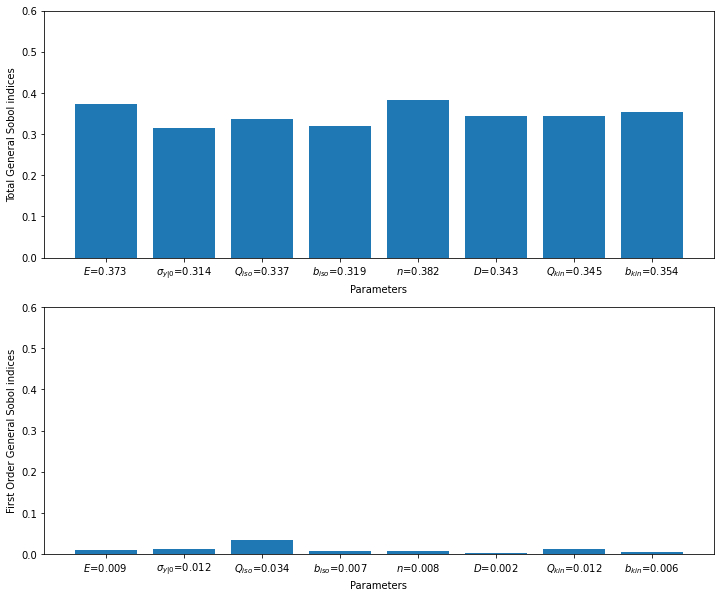

In [10]:
total_polynomial_degree = 4
number_of_random_variables = 8
polynomial_classes_of_random_variables = ['Legendre']*number_of_random_variables

Chaboche_PCE_Sobol = Chaboche_time_aware_PCE_surrogate(SampleSpace, f_at_quad_points, total_polynomial_degree, polynomial_classes_of_random_variables, Quad_coord_weight_matrix, chaboche_uniform_isoprob_transform)

print(f"Number of PCE terms: {Chaboche_PCE_Sobol.number_of_PCE_terms}")
print(f"Number of function evaluations: {f_at_quad_points.shape[0]}")
Chaboche_PCE_Sobol.generalised_Sobol()